In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [90]:
# Crea i dati per predire il prezzo tra 3 ggs

stock = "AAPL"

df = pd.read_csv(
    f"csv/{stock}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date fromat
) 

df["Train"] = df["Close"].shift(-3)
df.dropna(subset=['Train'], inplace=True)


Found 44 features with positive correlation to 'Train'.


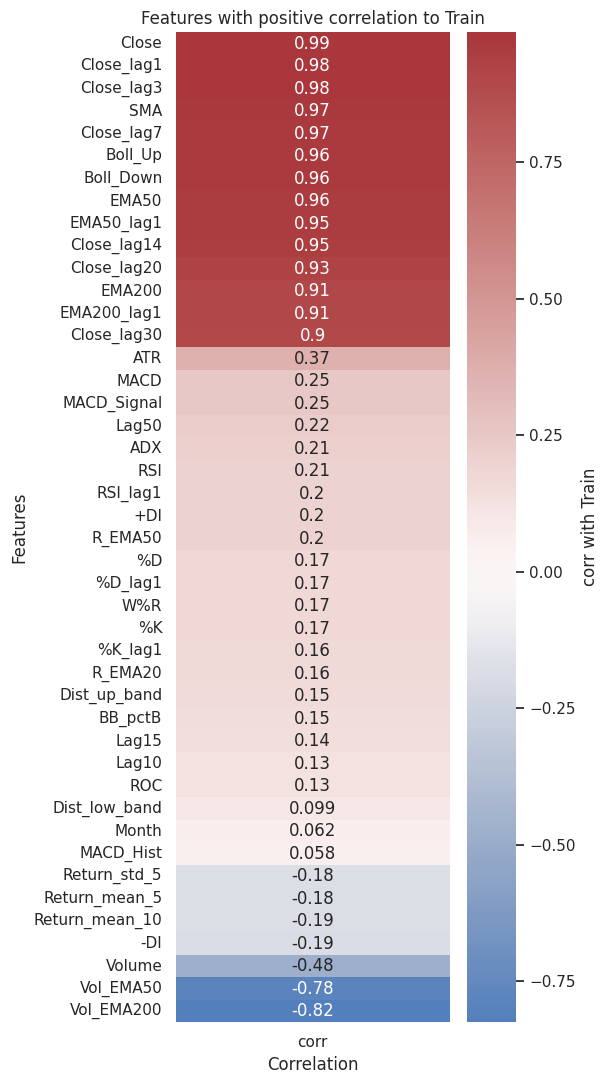

In [91]:
# List features with correlation > 0 w.r.t 'Train' and plot their correlations
if 'Train' not in df.columns:
    print("Column 'Train' not found in df. Run the data prep cell first.")
else:
    # Espressa anche close, per retrocmpatibiltà con il codice sotto stante
    corr = df.corr()
    # extract correlation with Train (drop the Train->Train self-correlation)
    corr_train = corr['Train'].drop(labels=['Train'], errors='ignore')
    significant_features = corr_train[abs(corr_train) > 0.05].sort_values(ascending=False)

    print(f"Found {len(significant_features)} features with positive correlation to 'Train'.")
    plt.figure(figsize=(6, max(4, 0.25 * len(significant_features))))
    sns.set_theme(style='white')
    # Convert to DataFrame for heatmap (required shape: (n, 1))
    pos_df = significant_features.to_frame('corr')
    ax = sns.heatmap(pos_df, annot=True, cmap='vlag', center=0, cbar_kws={'label': 'corr with Train'})
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Features')
    plt.title("Features with positive correlation to Train")
    plt.tight_layout()
    plt.show()

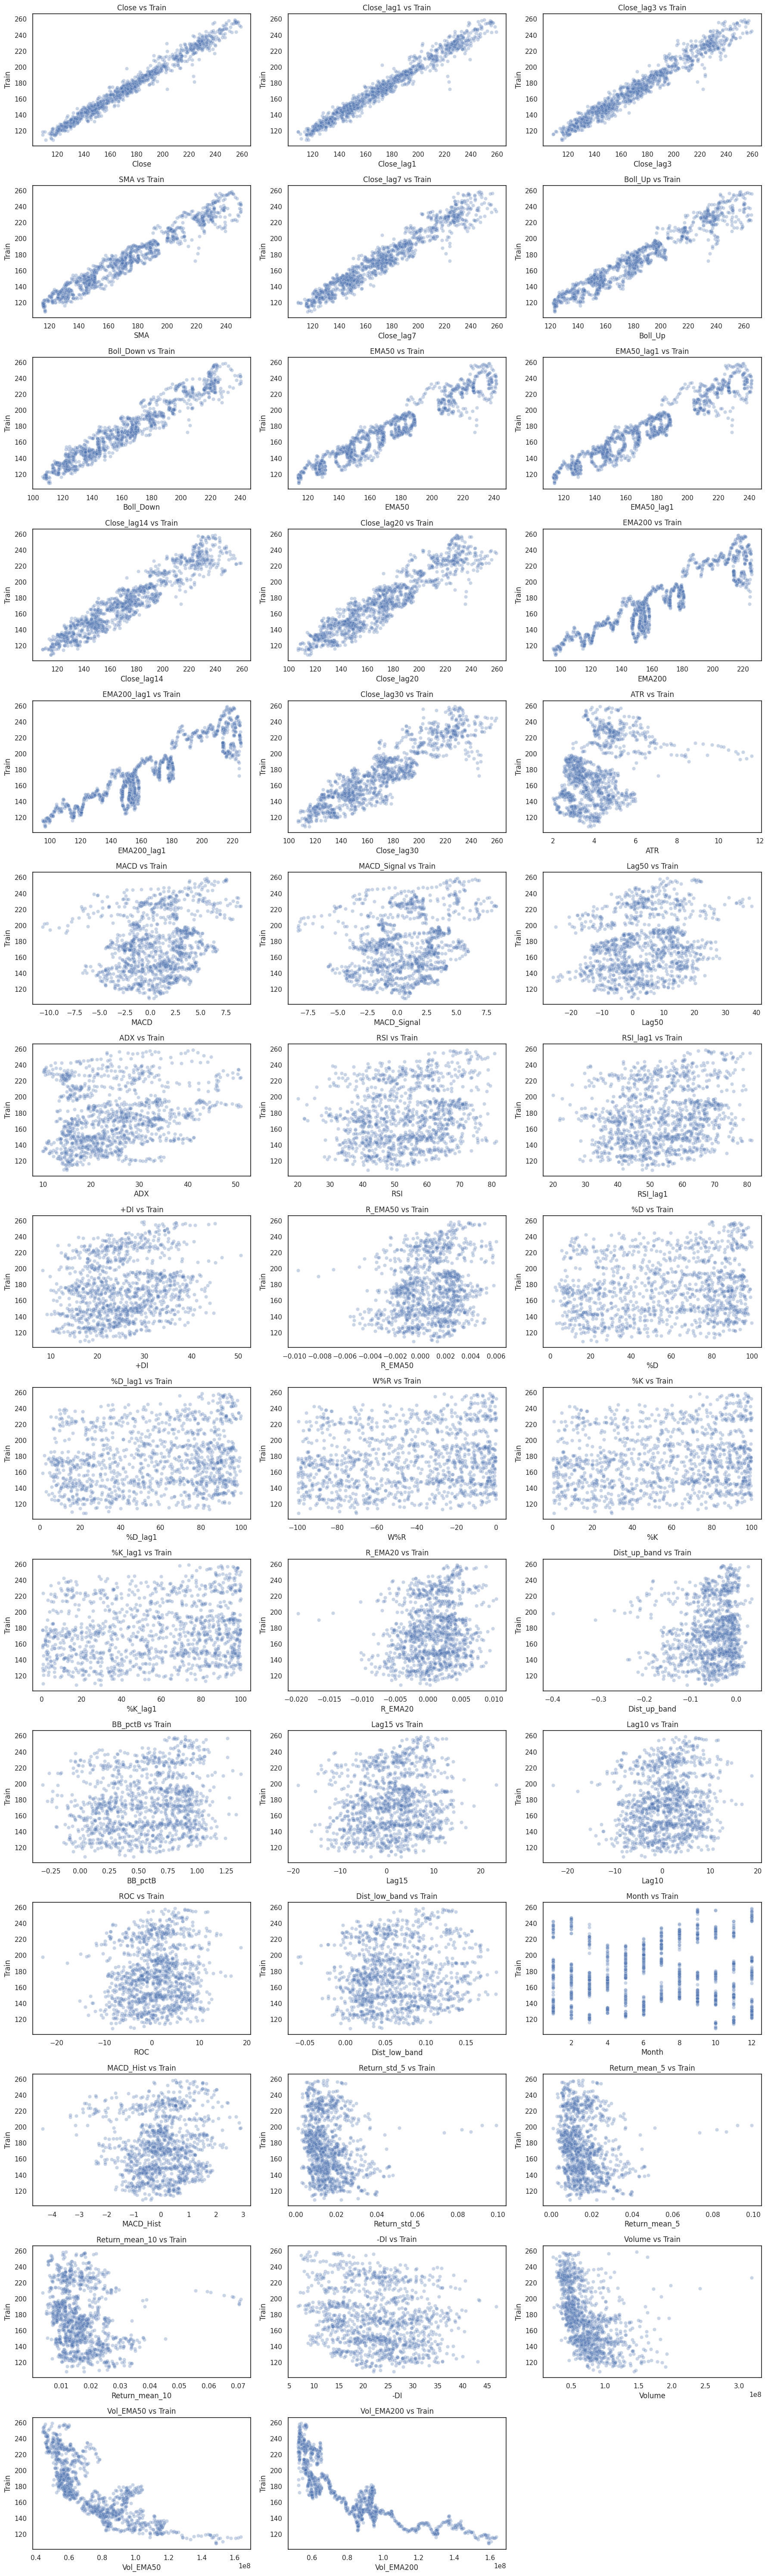

In [92]:
#Scatter plot
cols = list(df[significant_features.index].columns)
n = len(cols)
cols_per_row = 3
rows = (n + cols_per_row - 1) // cols_per_row
fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 6, rows * 4), squeeze=False)
axes_flat = axes.flatten()
for idx, col in enumerate(cols):
    ax = axes_flat[idx]
    sns.scatterplot(ax=ax, data=df, x=col, y='Train', alpha=0.3)
    ax.set_title(f"{col} vs Train")
# hide any unused subplots
for ax in axes_flat[n:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

In [97]:
#Data set 
featues = ["Close", "Close_lag1", "Close_lag3", "Close_lag7", "Close_lag14", "Close_lag20", "Close_lag30", "SMA", "Boll_Up", "Boll_Down", "EMA50", "EMA50_lag1", "EMA200", "EMA200_lag1"]

with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

data_set = []
tscv = TimeSeriesSplit(n_splits=6)
split = pd.Timestamp("2025-08-31")

for stock in stocks:

    dataf = pd.read_csv(
        f"csv/{stock}_indicators.csv",
        index_col=0,       # use first column ("Date") as index
        parse_dates=[0],    # parse it as datetime
        date_format="ISO8601" #Specify date fromat
    ) 

    dataf["Train"] = dataf["Close"].shift(-3)
    dataf.dropna(subset=['Train'], inplace=True)

    X = dataf[featues]
    Y = dataf["Train"]
    
    data_set.append({
        "X_train": X[X.index <= split].copy(),
        "X_test": X[X.index > split].copy(),
        "Y_train": Y[Y.index <= split].copy(),
        "Y_test": Y[Y.index > split].copy(),
        "Reality": dataf.loc[X[X.index > split].index, "Close"].copy()
    })


#for train_idx, test_idx in tscv.split(X):
#    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
#    
#    # Only keep the Close values that correspond to the test indices
#    data_set.append({
#        "X_train": X_train.copy(),
#        "X_test": X_test.copy(),
#        "Y_train": Y_train.copy(),
#        "Y_test": Y_test.copy(),
#        "Reality": df.loc[X_test.index, "Close"].copy()
#    })




Stock: ^GSPC
Best params: {'lasso__alpha': 1.0, 'lasso__max_iter': 10000}
RMSE: 54.7721 | MAE: 47.3097 | R2: 0.4295 | base R2: 0.4311
               coef  mean_abs_shap
Close       693.782    1.38754e+06
Close_lag3  57.7374         113554
Boll_Up     27.6027        52382.4
Close_lag1        0              0
Close_lag14       0              0
Close_lag7        0              0
Close_lag20       0              0
Close_lag30       0              0
SMA               0              0
Boll_Down         0              0
EMA50             0              0
EMA50_lag1        0              0
EMA200            0              0
EMA200_lag1       0              0


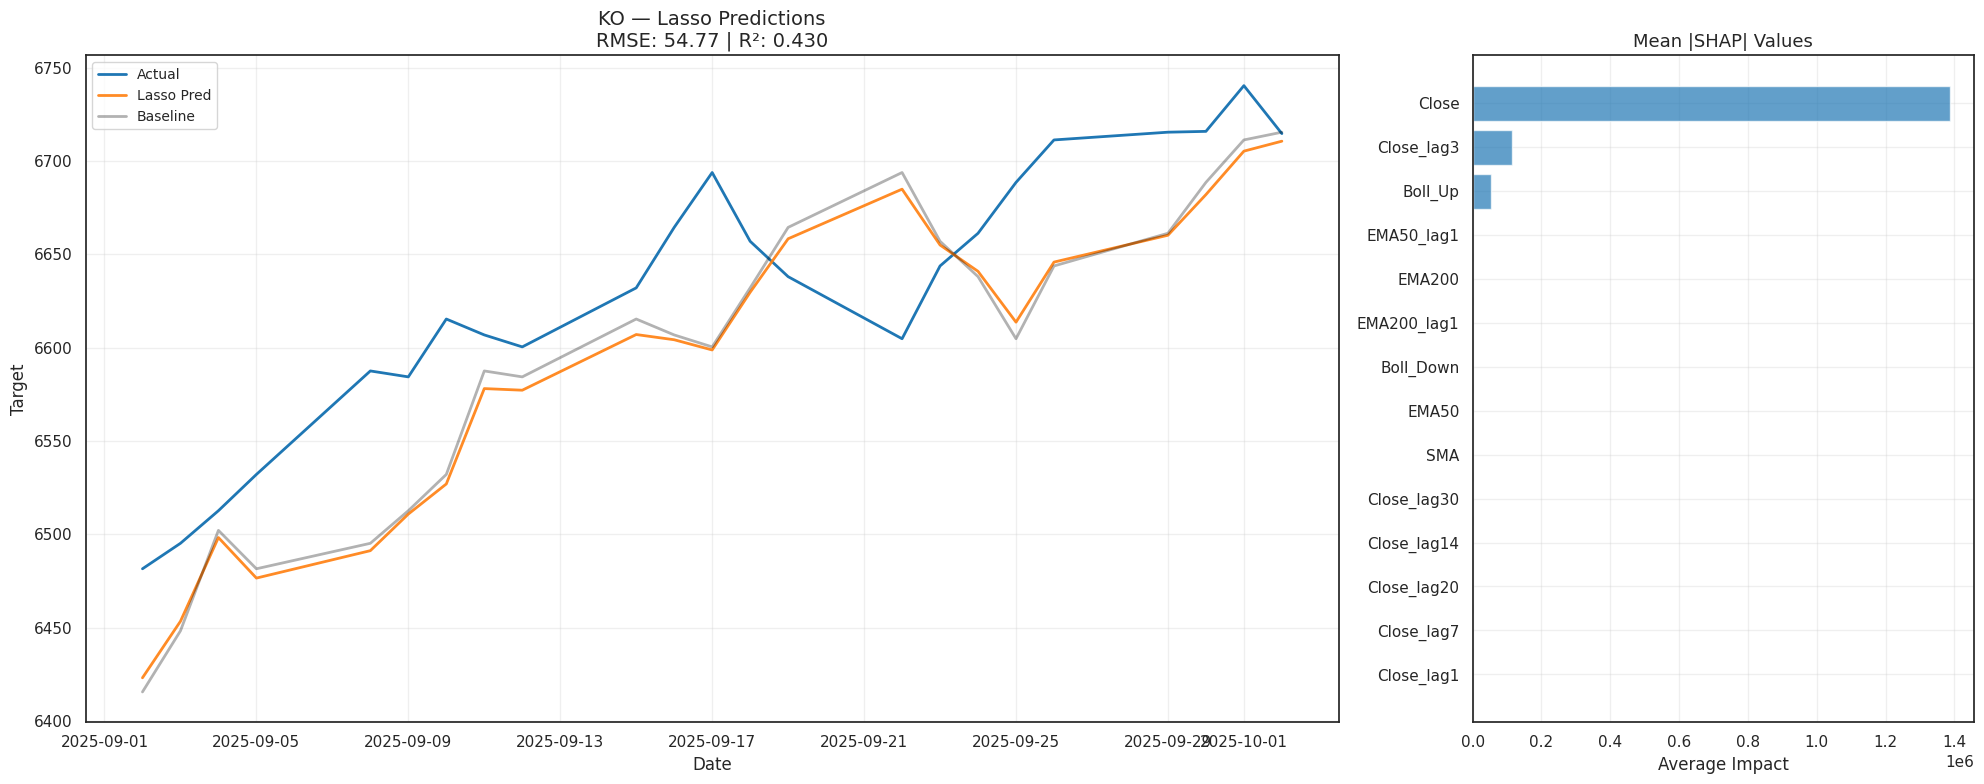

Stock: AAPL
Best params: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000}
RMSE: 7.6907 | MAE: 5.9143 | R2: 0.4366 | base R2: 0.4842
                 coef  mean_abs_shap
Close         32.0148        2279.33
Close_lag7    1.06684        67.2368
EMA200       0.856543        47.2981
Boll_Up       0.40307        26.0893
EMA200_lag1 0.0165925       0.913569
Close_lag1          0              0
Close_lag20         0              0
Close_lag14         0              0
Close_lag3          0              0
Close_lag30         0              0
Boll_Down           0              0
SMA                 0              0
EMA50_lag1          0              0
EMA50               0              0


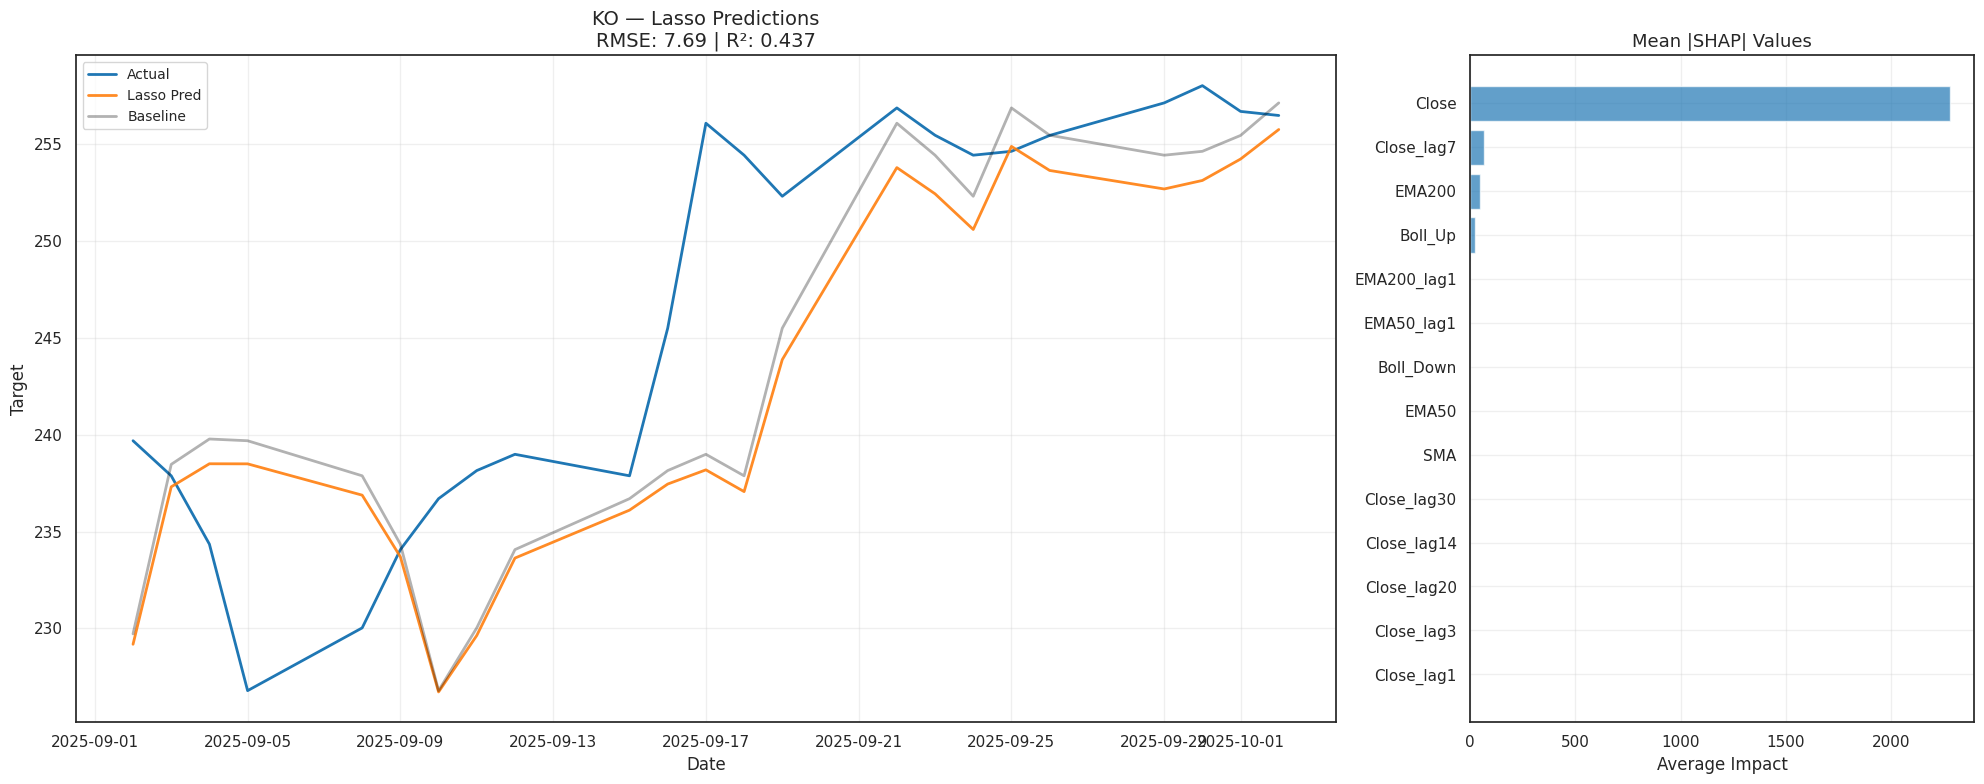

Stock: NVDA
Best params: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000}
RMSE: 5.5617 | MAE: 4.4351 | R2: 0.1654 | base R2: 0.0697
                coef  mean_abs_shap
Close         43.452        5321.78
Boll_Up      3.39808        429.699
Close_lag3   2.38807        289.273
Close_lag1  0.395188        48.1013
Close_lag14        0              0
Close_lag7         0              0
Close_lag20        0              0
Close_lag30       -0              0
SMA                0              0
Boll_Down          0              0
EMA50              0              0
EMA50_lag1         0              0
EMA200             0              0
EMA200_lag1        0              0


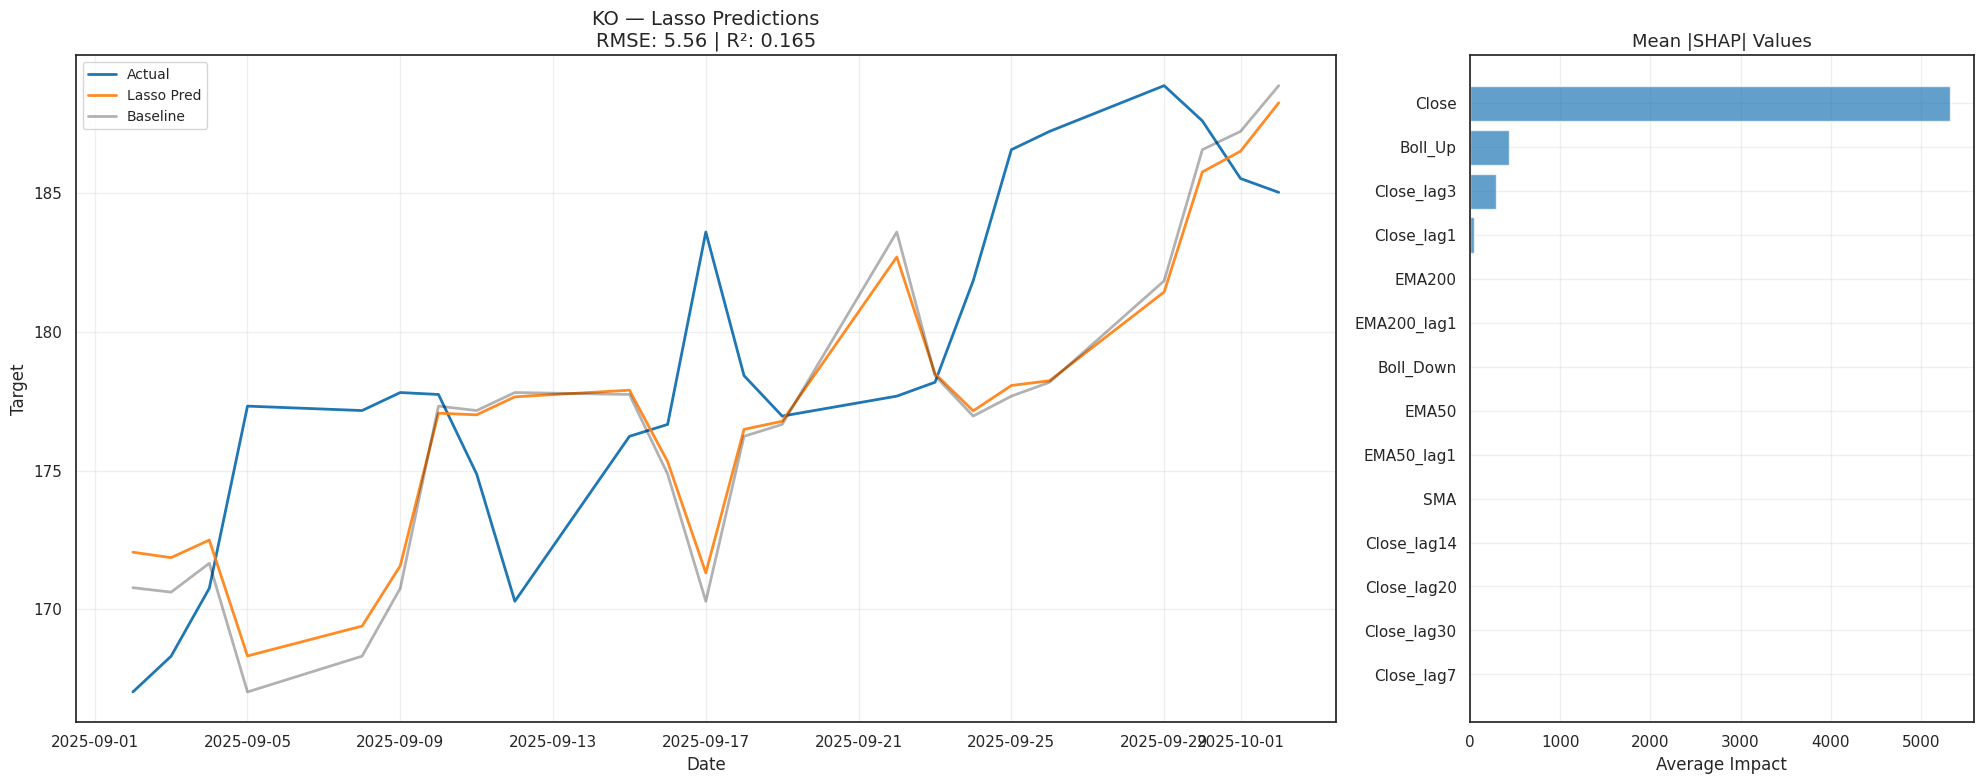

Stock: KO
Best params: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000}
RMSE: 0.7025 | MAE: 0.5559 | R2: -0.1875 | base R2: -0.4253
                  coef  mean_abs_shap
Close          5.35627         32.441
Close_lag3    0.122769       0.792378
EMA200       0.0904287       0.829177
Boll_Up     0.00643681      0.0479428
Close_lag1           0              0
Close_lag7           0              0
Close_lag20          0              0
Close_lag14          0              0
SMA                  0              0
Close_lag30          0              0
Boll_Down            0              0
EMA50                0              0
EMA50_lag1           0              0
EMA200_lag1          0              0


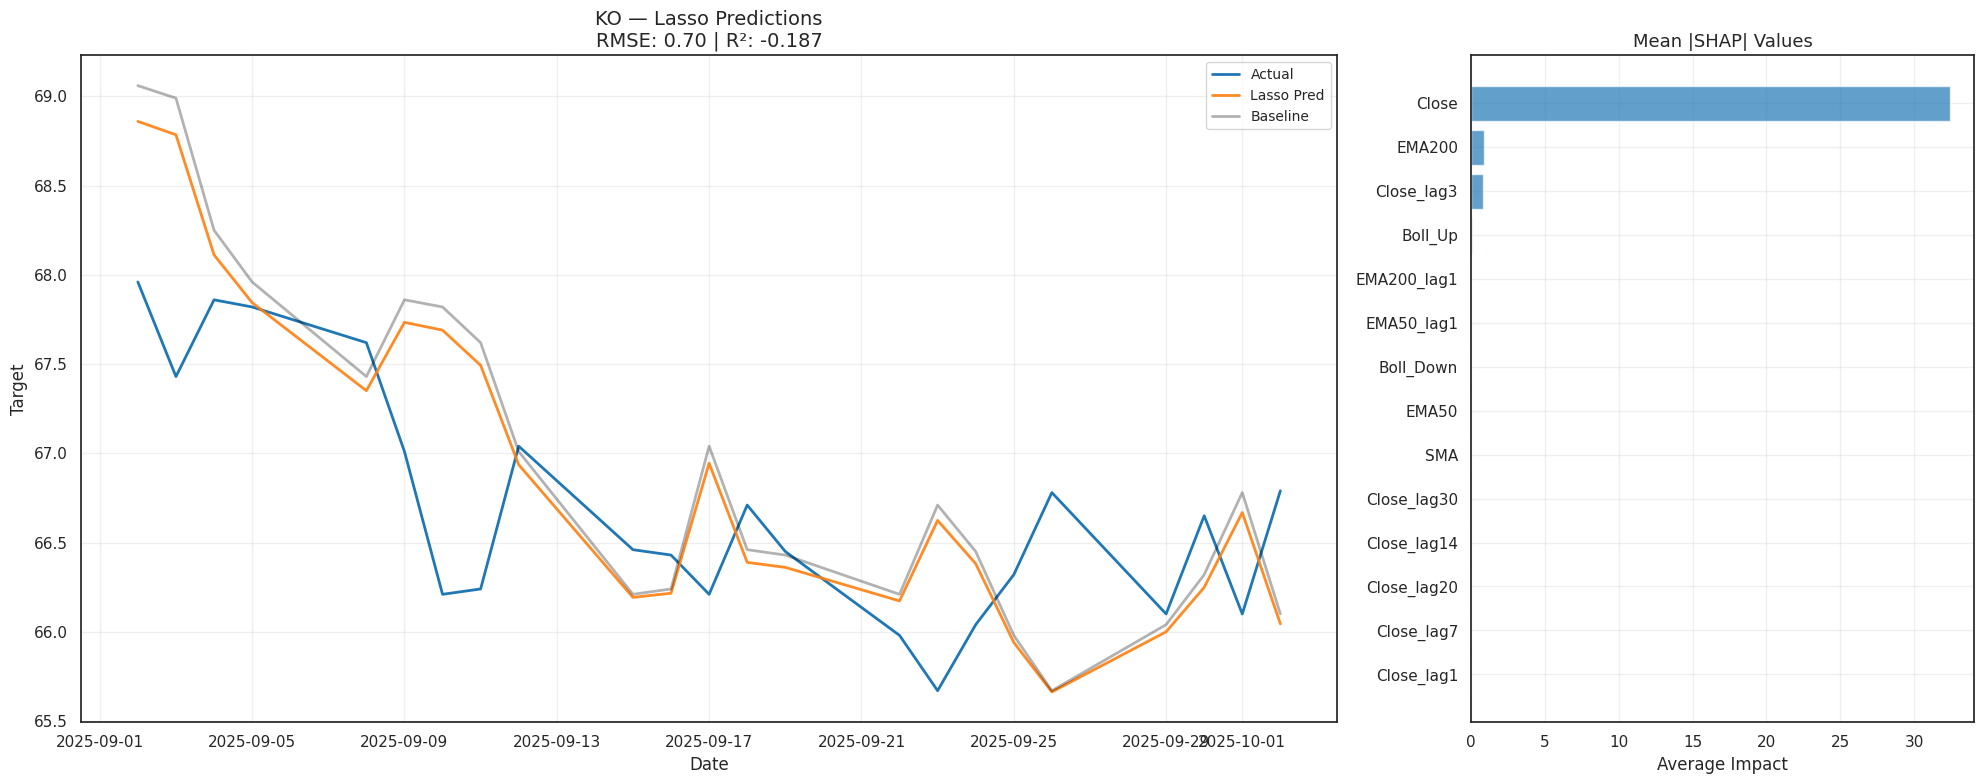

In [98]:
#Lasso regression
for i, data in enumerate(data_set):
    pipe = make_pipeline(StandardScaler(), Lasso(random_state=42, max_iter=20000))

    param_grid = {
        'lasso__alpha': [0.1, 0.5, 1.0, 2.0], 
        'lasso__max_iter': [10000, 50000, 100000]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stocks[i]}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # coefficients
    lasso = best.named_steps['lasso']
    coefs = pd.Series(lasso.coef_, index=data["X_train"].columns)

    # compute SHAP values (try recommended masker, fallback to Explainer)
    shap_values = None
    try:
        masker = shap.maskers.Independent(data["X_train"])  # type: ignore
        explainer = shap.LinearExplainer(lasso, masker=masker)
        shap_values = explainer(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(lasso, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (coef + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — coefficients ordered by |coef|:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        if hasattr(shap_values, "values"):
            sv = shap_values.values
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # --- ONE figure with two panels ---
    fig, (ax_main, ax_shap) = plt.subplots(
        1, 2,
        figsize=(20, 8),                   # this WILL now control the size
        gridspec_kw={'width_ratios': [2.5, 1]}
    )

    # ---- MAIN PLOT ----
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='Lasso Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='Baseline', color='#000000', linewidth=2, alpha=0.3)

    ax_main.set_title(f"{stock} — Lasso Predictions\nRMSE: {rmse:.2f} | R²: {r2:.3f}", fontsize=14)
    ax_main.set_xlabel("Date", fontsize=12)
    ax_main.set_ylabel("Target", fontsize=12)
    ax_main.legend(fontsize=10)
    ax_main.grid(alpha=0.3)

    # ---- SHAP PLOT ----
    try:
        if hasattr(shap_values, "values"):
            sv = shap_values.values # type: ignore
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]

        # Compute mean absolute SHAP values
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)
        shap_series = shap_series.sort_values(ascending=True)

        # Horizontal bar chart
        ax_shap.barh(shap_series.index, shap_series.values, color="#1f77b4", alpha=0.7)
        ax_shap.set_title("Mean |SHAP| Values", fontsize=13)
        ax_shap.set_xlabel("Average Impact", fontsize=12)
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center', fontsize=10)
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()

Stock: ^GSPC
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 55.3948 | MAE: 48.4153 | R2: 0.4165 | base R2: 0.4311
                coef  mean_abs_shap
Close        586.027    1.17203e+06
Close_lag1    90.542         180118
Close_lag3   59.1955         116421
Boll_Up      54.8165         104027
Close_lag20 -44.3877        82670.3
EMA50        21.5462          39767
SMA          21.4565        41382.9
Close_lag7   -13.818        26924.5
EMA200_lag1 -8.93627          14443
Close_lag30  8.49534        15666.3
Close_lag14  6.17156        11710.3
EMA200       -2.0647        3344.89
Boll_Down         -0              0
EMA50_lag1         0              0


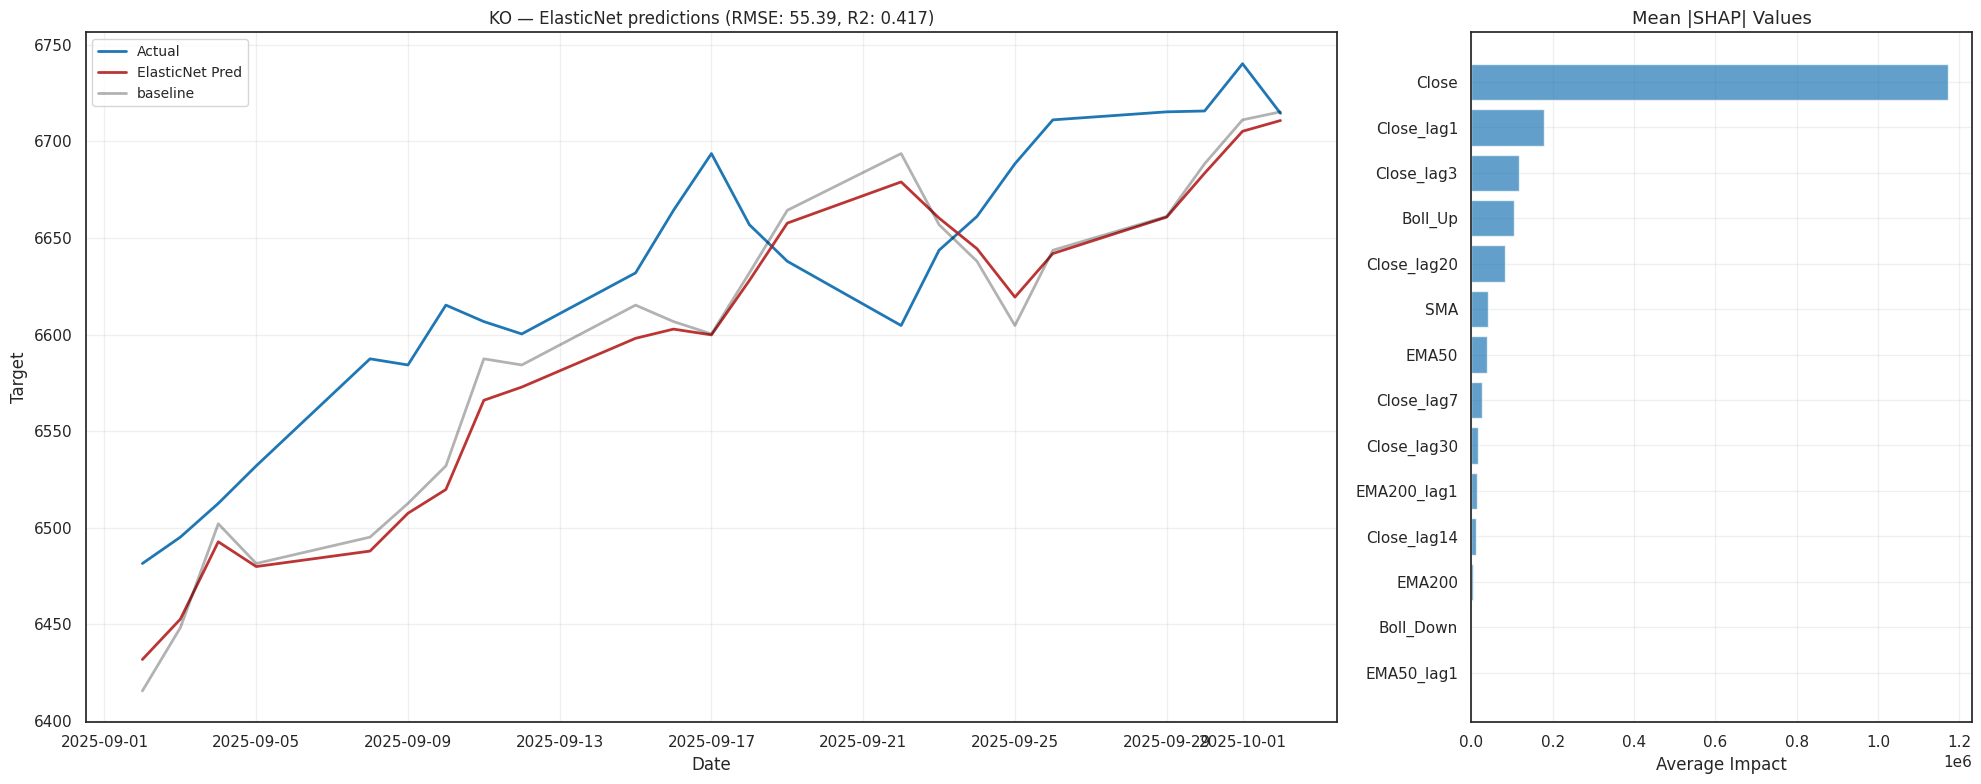

Stock: AAPL
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 7.5847 | MAE: 5.7643 | R2: 0.4520 | base R2: 0.4842
                 coef  mean_abs_shap
Close         30.3709        2162.29
SMA           1.65291        103.122
Boll_Up       1.56431        101.252
EMA50_lag1   -1.51017         81.716
Close_lag20   -1.2469        67.9374
EMA200        1.05888        58.4708
Close_lag7   0.810004          51.05
Close_lag1    0.68841        48.2061
EMA200_lag1  0.494539        27.2289
Close_lag30  0.404888        19.2681
EMA50       -0.351022        19.2292
Close_lag3   0.325525        22.1259
Boll_Down    0.180969        10.8672
Close_lag14         0              0


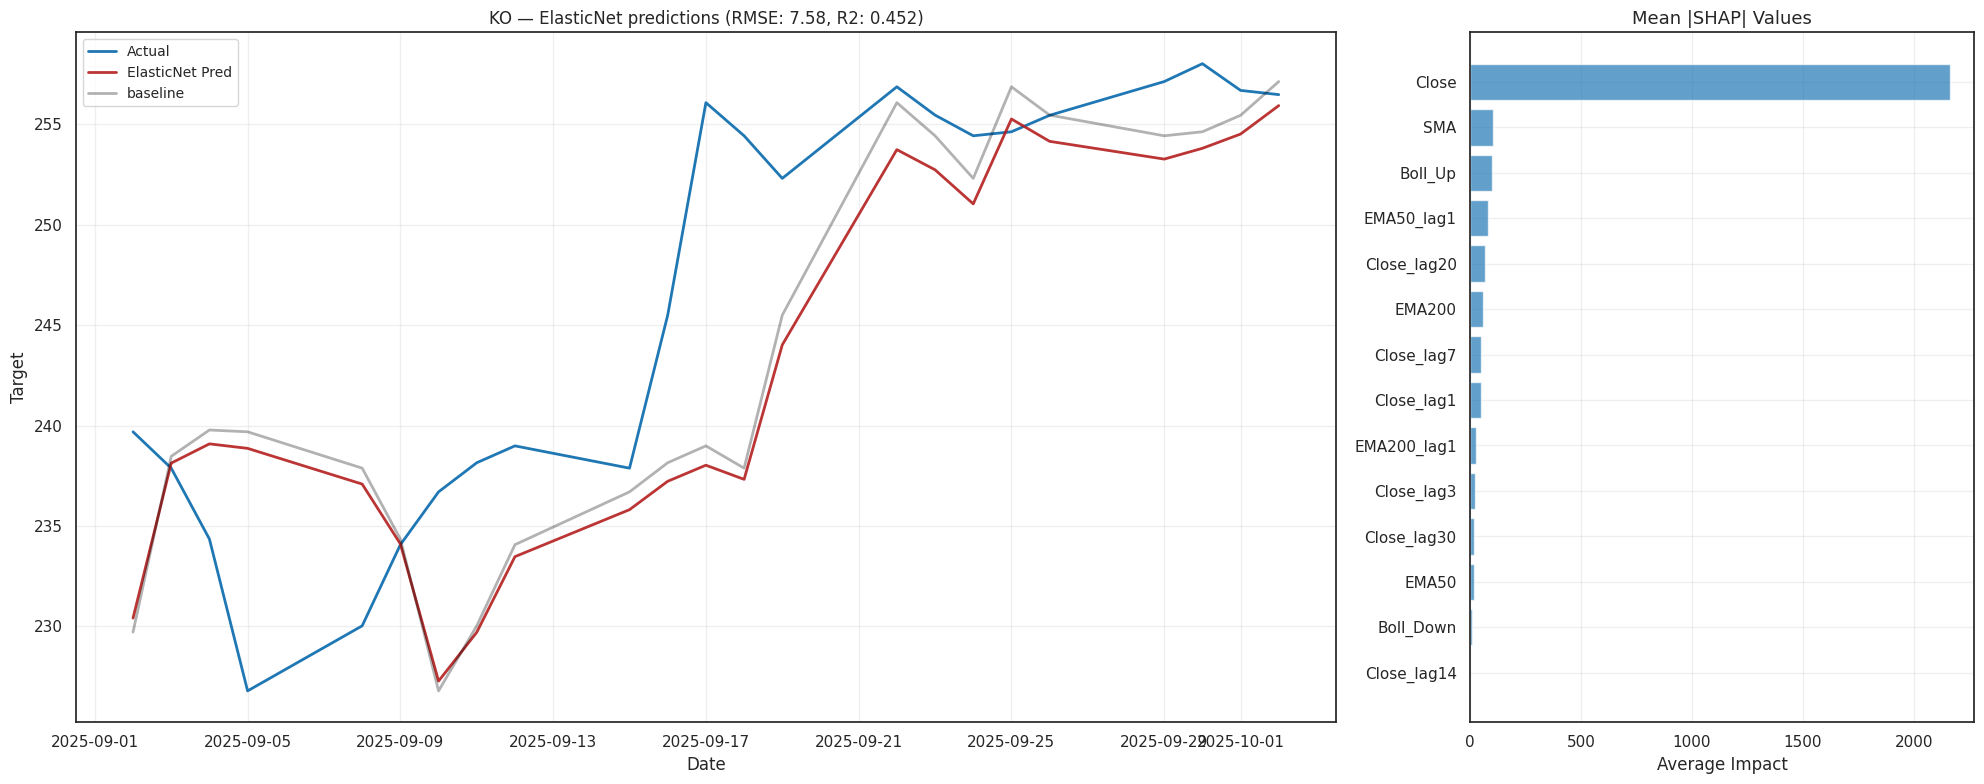

Stock: NVDA
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 6.0853 | MAE: 4.8661 | R2: 0.0009 | base R2: 0.0697
                 coef  mean_abs_shap
Close         32.5606        3987.85
Close_lag1     8.3951        1021.83
Boll_Up       7.14282        903.235
Close_lag30  -4.15828        530.355
Close_lag3    2.74984        333.095
EMA200        1.16203        117.962
SMA           0.70482        86.6213
Close_lag14  0.684327        84.7547
EMA200_lag1  0.670073        67.8804
Close_lag20 -0.242361        30.6577
Close_lag7          0              0
Boll_Down           0              0
EMA50_lag1          0              0
EMA50               0              0


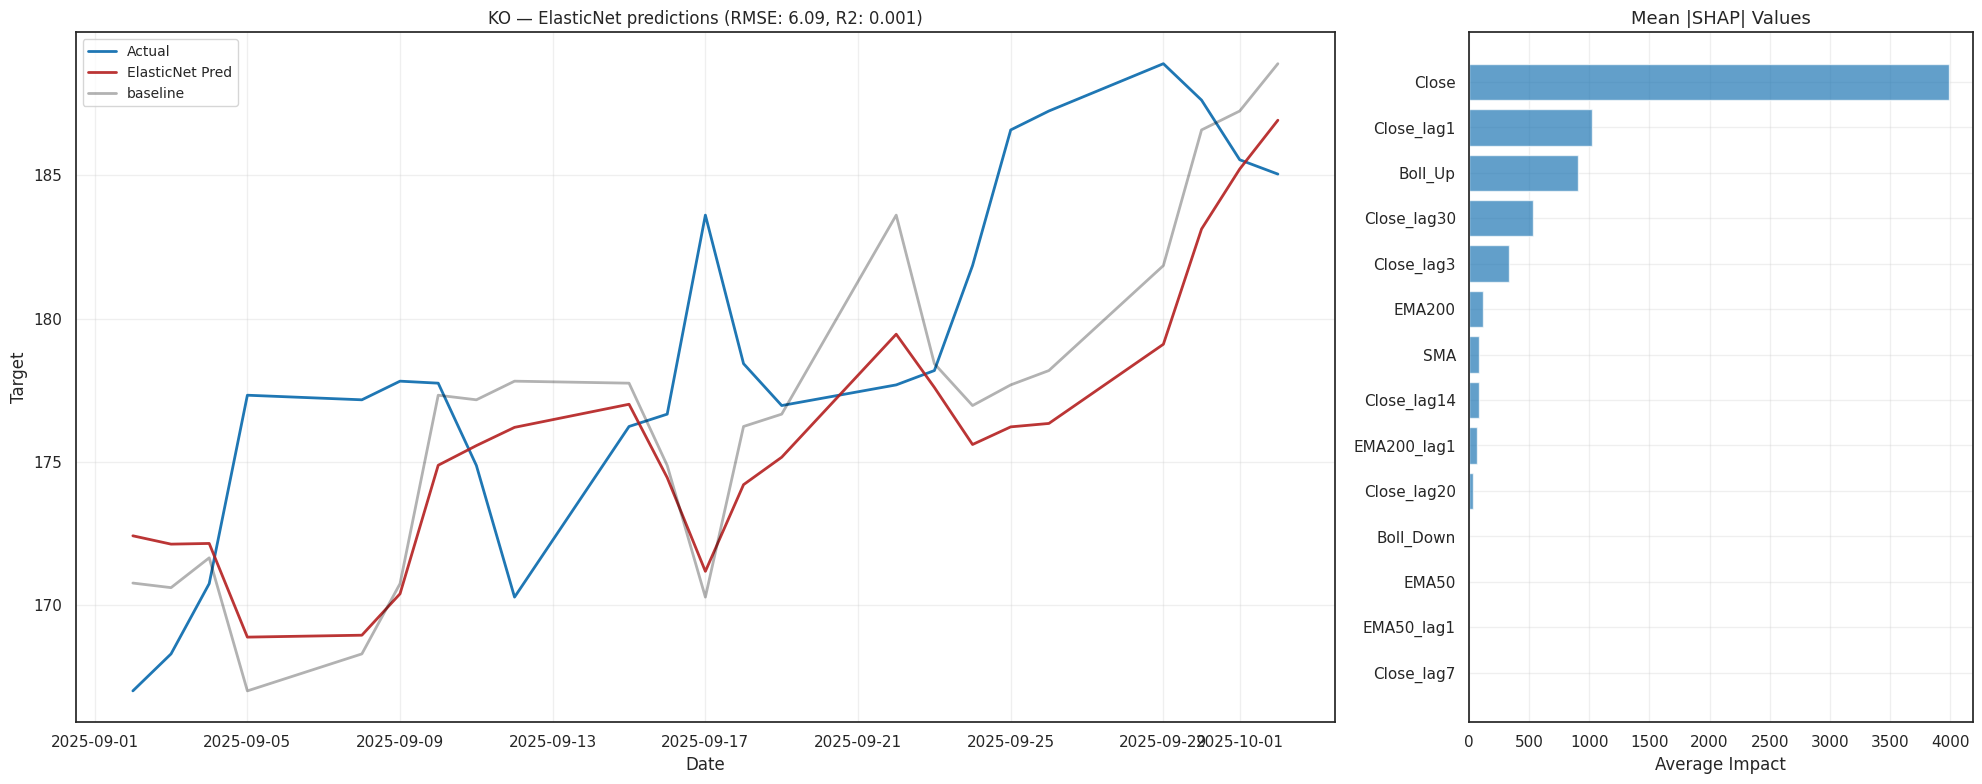

Stock: KO
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 0.7669 | MAE: 0.5739 | R2: -0.4155 | base R2: -0.4253
                  coef  mean_abs_shap
Close          5.04806        30.5743
EMA200        0.241278        2.21238
Close_lag1    0.213188        1.32513
Close_lag30  -0.206641        1.80594
Close_lag3    0.191682        1.23716
Boll_Up       0.180463        1.34412
Boll_Down   -0.0329153       0.243445
EMA200_lag1  0.0239671       0.220513
Close_lag7           0              0
Close_lag14          0              0
Close_lag20         -0              0
SMA                  0              0
EMA50_lag1           0              0
EMA50                0              0


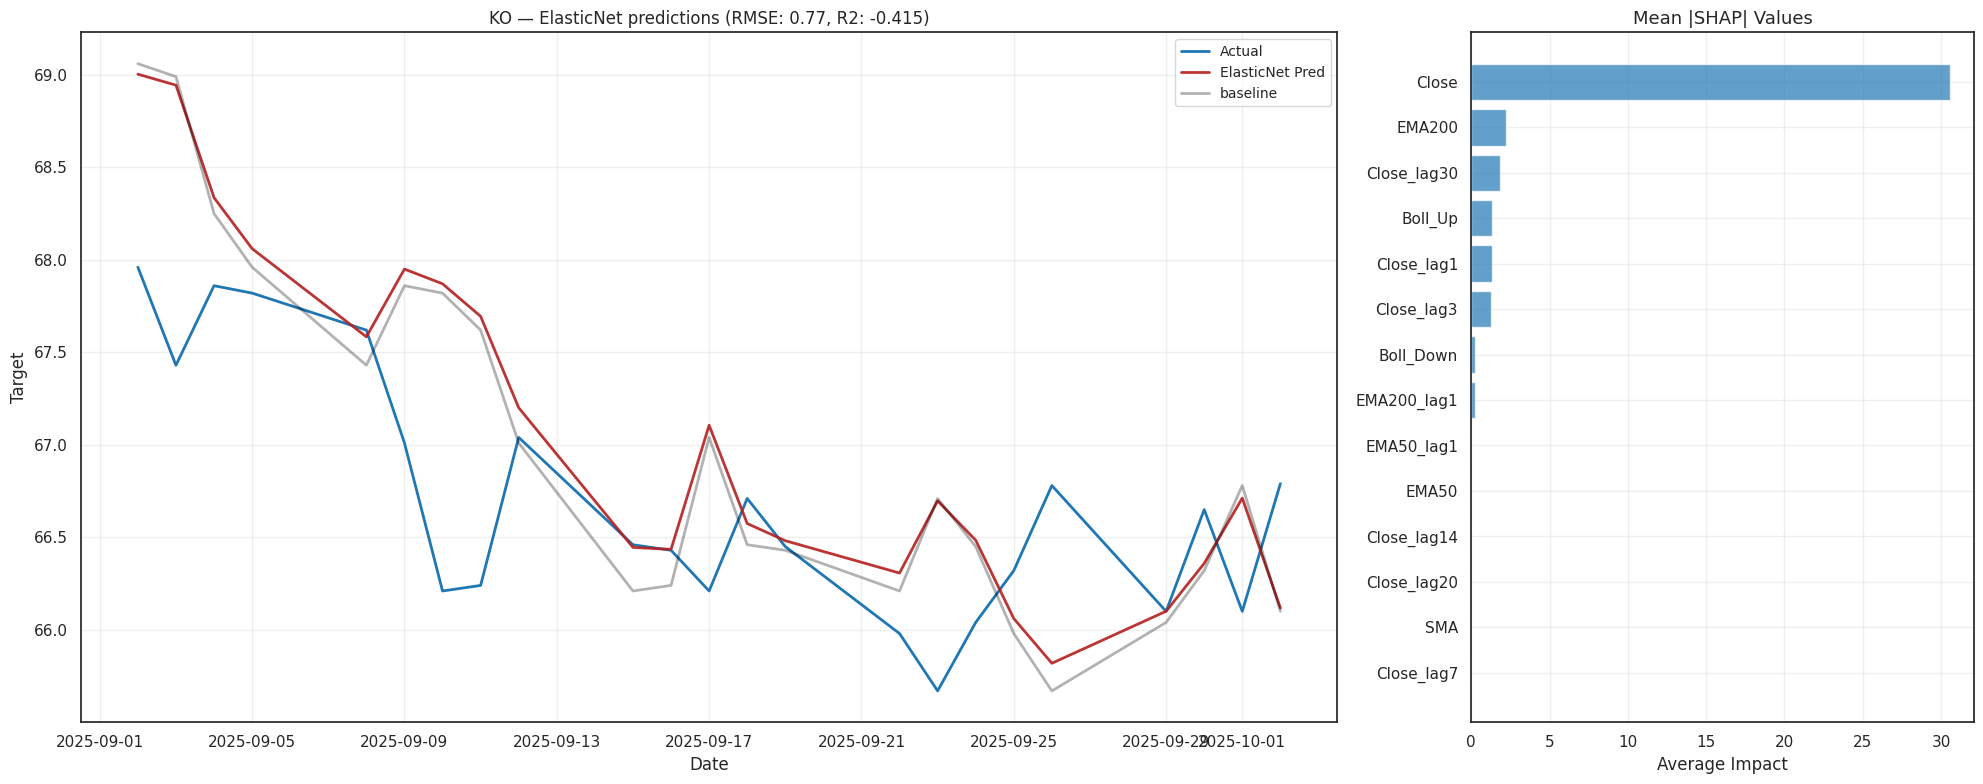

In [99]:
# Elatic-net
for i, data in enumerate(data_set):
    pipe = make_pipeline(StandardScaler(), ElasticNet(random_state=42, max_iter=20000))

    param_grid = {
        'elasticnet__alpha': [0.01, 0.1, 0.5, 1.0],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stocks[i]}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # display top coefficients
    try:
        enet = best.named_steps['elasticnet']
        coefs = pd.Series(enet.coef_, index=data["X_train"].columns)
    except Exception:
        pass

    # compute SHAP values (try recommended masker, fallback to Explainer)
    shap_values = None
    try:
        masker = shap.maskers.Independent(data["X_train"])  # type: ignore
        explainer = shap.LinearExplainer(enet, masker=masker)
        shap_values = explainer(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(enet, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (coef + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — coefficients ordered by |coef|:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        if hasattr(shap_values, "values"):
            sv = shap_values.values
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # --- ONE figure with two panels ---
    fig, (ax_main, ax_shap) = plt.subplots(
        1, 2,
        figsize=(20, 8),                   # this WILL now control the size
        gridspec_kw={'width_ratios': [2.5, 1]}
    )

    # ---- MAIN PLOT ----
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='ElasticNet Pred', color='#b41f1f', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.3)

    ax_main.set_title(f"{stock} — ElasticNet predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    ax_main.set_xlabel("Date", fontsize=12)
    ax_main.set_ylabel("Target", fontsize=12)
    ax_main.legend(fontsize=10)
    ax_main.grid(alpha=0.3)

    # ---- SHAP PLOT (manual bar chart) ----
    try:
        if hasattr(shap_values, "values"):
            sv = shap_values.values # type: ignore
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]

        # Compute mean absolute SHAP values
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)
        shap_series = shap_series.sort_values(ascending=True)

        # Horizontal bar chart
        ax_shap.barh(shap_series.index, shap_series.values, color="#1f77b4", alpha=0.7)
        ax_shap.set_title("Mean |SHAP| Values", fontsize=13)
        ax_shap.set_xlabel("Average Impact", fontsize=12)
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center', fontsize=10)
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()

Stock: ^GSPC
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 1000, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 193.2954 | MAE: 179.9197 | R2: -6.1046 | base R2: 0.4311
Top features (ordered by importance) with corresponding mean |SHAP|:
                  coef  mean_abs_shap
Close         0.206928        457.833
Close_lag1    0.204588        272.282
Close_lag3    0.174681        267.122
SMA           0.160248        206.346
Close_lag7   0.0878107        156.427
EMA50        0.0445206        23.1874
Boll_Down    0.0404257        91.9712
Close_lag20   0.033133        62.9799
EMA200       0.0278428         110.45
EMA200_lag1  0.0075685        25.4848
Close_lag14 0.00357745        41.8083
Boll_Up     0.00338924        43.0354
EMA50_lag1  0.00275945        4.38862
Close_lag30 0.00252687        9.35209


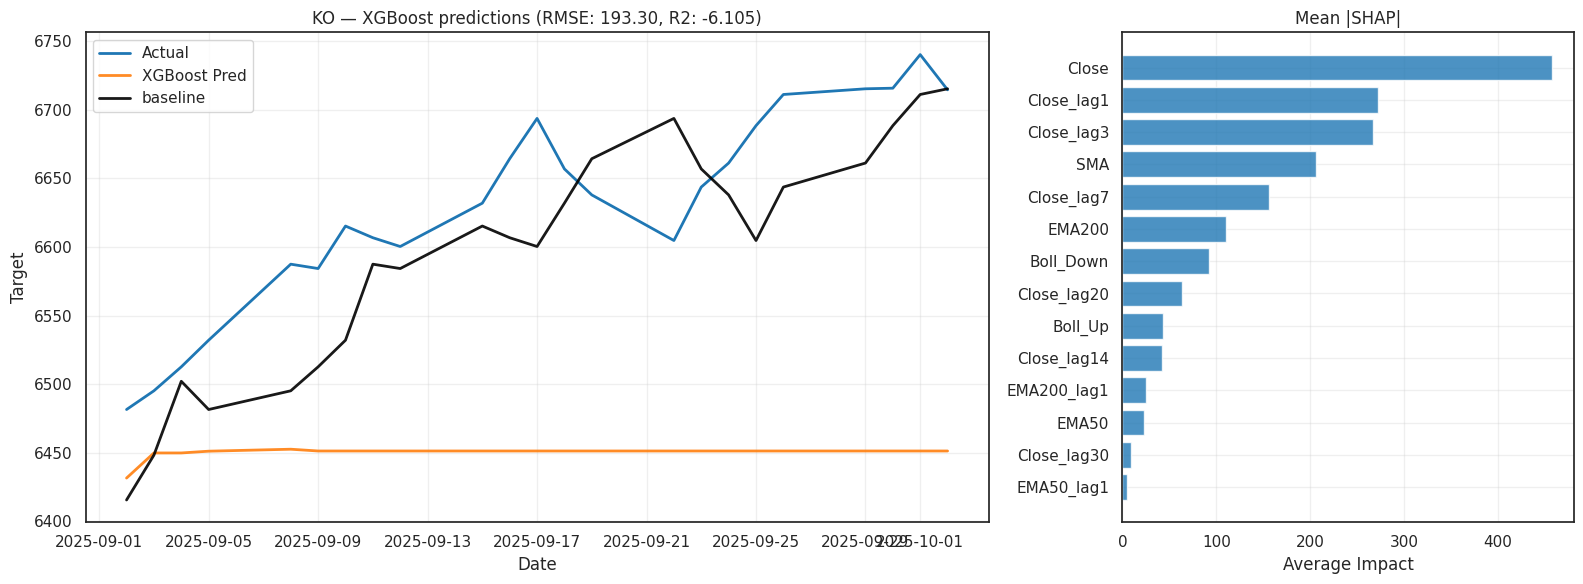

Stock: AAPL
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 1000, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 7.3319 | MAE: 5.5361 | R2: 0.4879 | base R2: 0.4842
Top features (ordered by importance) with corresponding mean |SHAP|:
                  coef  mean_abs_shap
Close         0.550151        35.6273
Close_lag1     0.20688        10.9057
Close_lag3    0.138345         6.6631
Boll_Up      0.0184042        3.84028
Close_lag7    0.014107        2.36249
SMA           0.013701        2.45107
Boll_Down    0.0117658       0.637695
EMA200        0.010358         1.4123
EMA200_lag1 0.00908368       0.299109
EMA50        0.0072979       0.436015
EMA50_lag1  0.00589176       0.378003
Close_lag14 0.00568818        2.47826
Close_lag30 0.00431457       0.802334
Close_lag20 0.00401207        0.93553


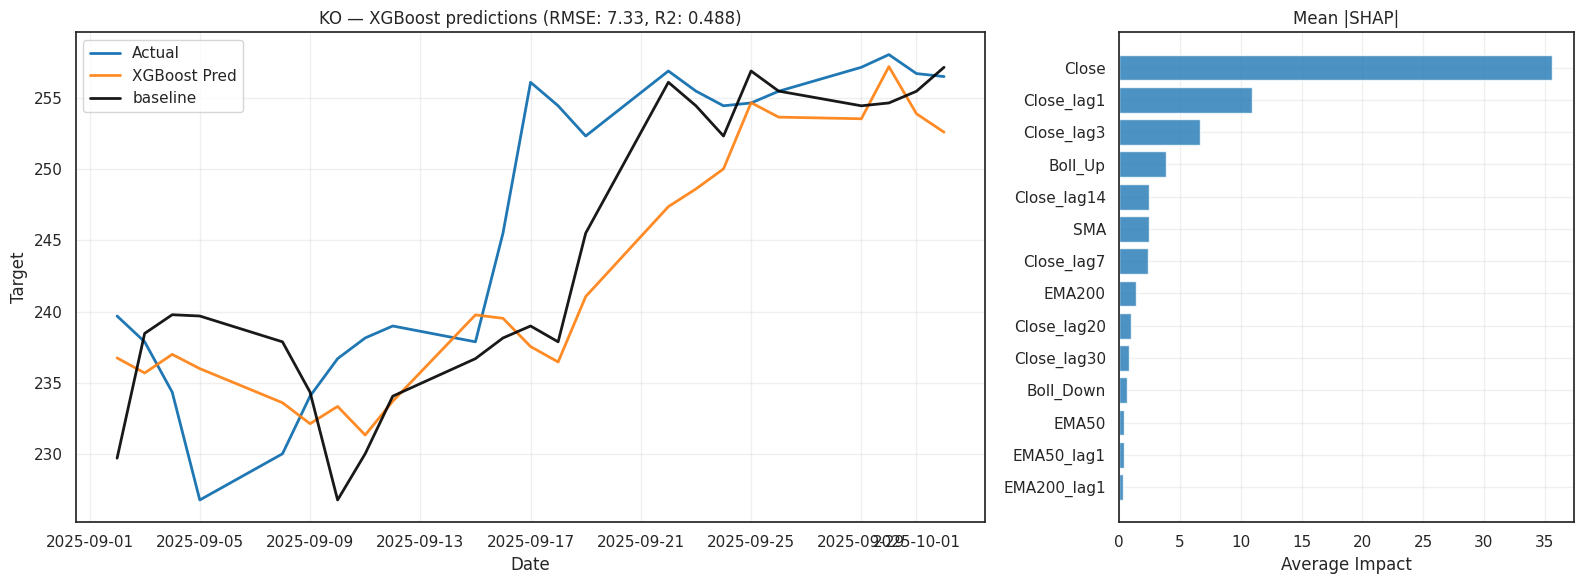

Stock: NVDA
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 1000, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 6.9246 | MAE: 5.4810 | R2: -0.2938 | base R2: 0.0697
Top features (ordered by importance) with corresponding mean |SHAP|:
                  coef  mean_abs_shap
Close_lag3    0.239096        21.0179
Close         0.203579        33.3622
Close_lag20   0.189992        10.2779
Close_lag1     0.13573          21.04
Close_lag7    0.102285         13.564
Close_lag14  0.0799893        6.62218
Close_lag30  0.0140589       0.396366
SMA         0.00949045        4.22183
Boll_Up      0.0077121        1.62995
EMA50       0.00622852       0.651847
EMA200      0.00409106        4.93607
Boll_Down   0.00301217        1.79949
EMA200_lag1 0.00299153        1.31621
EMA50_lag1  0.00174366        0.30963


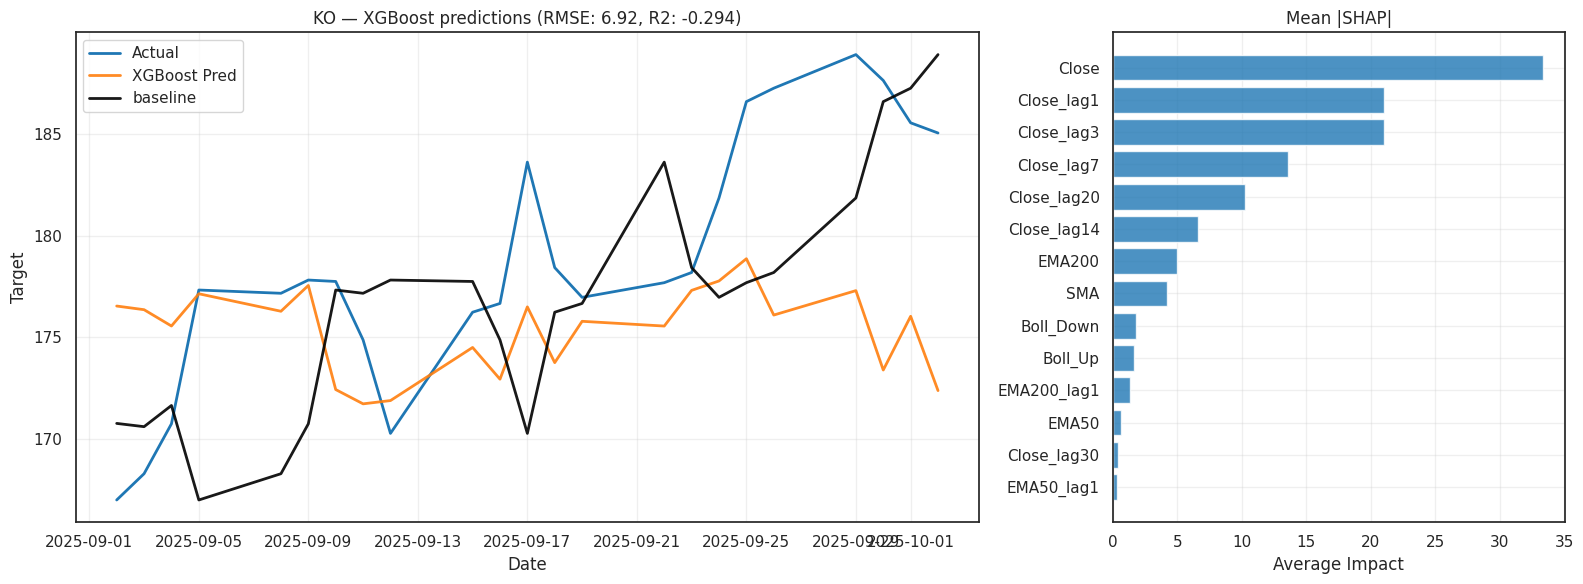

Stock: KO
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 800, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 1.1363 | MAE: 0.9797 | R2: -2.1073 | base R2: -0.4253
Top features (ordered by importance) with corresponding mean |SHAP|:
                  coef  mean_abs_shap
Close          0.58485        4.20849
Close_lag1    0.279715        1.10498
Close_lag3   0.0477011       0.614664
EMA200       0.0154348        0.16579
Boll_Up        0.01205       0.192267
EMA200_lag1  0.0100691      0.0645308
SMA          0.0084325      0.0575273
Close_lag7  0.00677636      0.0151654
EMA50_lag1  0.00665953      0.0222417
EMA50       0.00655799       0.115227
Boll_Down   0.00650441      0.0289379
Close_lag20   0.005339        0.11477
Close_lag30 0.00517327      0.0892001
Close_lag14 0.00473713      0.0302452


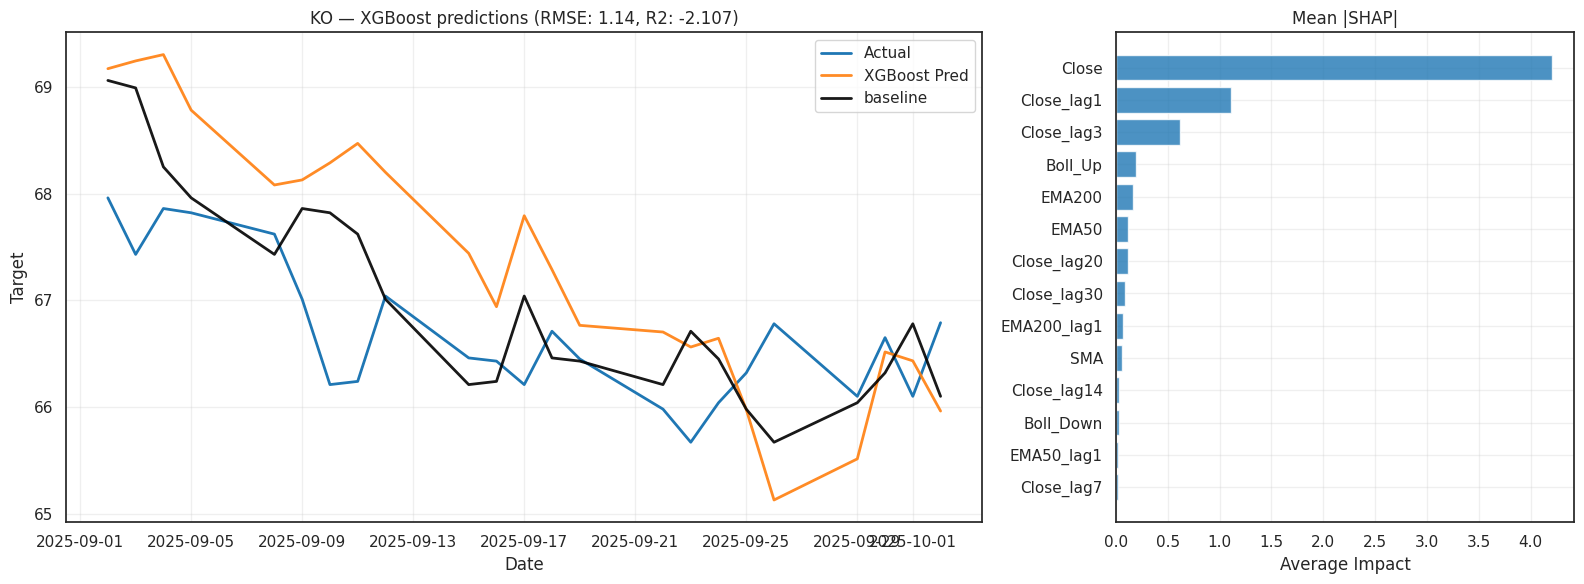

In [100]:
for i,data in enumerate(data_set):
    pipe = Pipeline([('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0))])

    param_grid = {
        'xgb__n_estimators': [300, 800, 1000],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__subsample': [0.4, 0.8],
        'xgb__colsample_bytree': [0.8],
        'xgb__reg_lambda': [2],
        'xgb__min_child_weight': [5]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stocks[i]}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # feature importances as 'coef' equivalent
    model = best.named_steps['xgb']
    try:
        coefs = pd.Series(model.feature_importances_, index=data["X_train"].columns)
    except Exception:
        coefs = pd.Series(0, index=data["X_train"].columns)

    # compute SHAP values (TreeExplainer preferred)
    shap_values = None
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(model, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (importance + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — features ordered by importance:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        # shap_values may be list (multi-output) or array
        if isinstance(shap_values, list):
            if len(shap_values) == 1:
                sv = shap_values[0]
            else:
                sv = np.array(shap_values).mean(axis=0)
        elif hasattr(shap_values, "values"):
            sv = shap_values.values  # type: ignore
        else:
            sv = shap_values

        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print("Top features (ordered by importance) with corresponding mean |SHAP|:")
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # single figure: left = actual vs predicted, right = SHAP summary (bar)
    fig, (ax_main, ax_shap) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

    # main time-series plot on left
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='XGBoost Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.9)
    ax_main.set_title(f"{stock} — XGBoost predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    ax_main.set_xlabel("Date")
    ax_main.set_ylabel("Target")
    ax_main.legend()
    ax_main.grid(alpha=0.3)

    # SHAP bar summary on right
    try:
        plot_series = combined["mean_abs_shap"].sort_values(ascending=True)
        ax_shap.barh(plot_series.index, plot_series.values, color="#1f77b4", alpha=0.8)
        ax_shap.set_title("Mean |SHAP|")
        ax_shap.set_xlabel("Average Impact")
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center')
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()